# Fatal police shootings in the US since 2015 with additional US census data

The following *description* and the *data* used in this notebook have been taken from [kaggle website](https://www.kaggle.com/kwullum/fatal-police-shootings-in-the-us). For further details on the story, the data and its collection feel free to click on the link and explore related resources.

## Description

In this section the problem description is reported to have a better understanding on the data.

The 2014 killing of Michael Brown in Ferguson, Missouri, began the protest movement culminating in Black Lives Matter and an increased focus on police accountability nationwide.

Since Jan. 1, 2015, The Washington Post has been compiling a database of every fatal shooting in the US by a police officer in the line of duty.
It's difficult to find reliable data from before this period, as police killings haven't been comprehensively documented, and the statistics on police brutality are much less available. As a result, a vast number of cases go unreported.

The Washington Post is tracking more than a dozen details about each killing - including the race, age and gender of the deceased, whether the person was armed, and whether the victim was experiencing a mental-health crisis. They have gathered this information from law enforcement websites, local new reports, social media, and by monitoring independent databases such as "Killed by police" and "Fatal Encounters". The Post has also conducted additional reporting in many cases.

There are four additional datasets. These are US census data on poverty rate, high school graduation rate, median household income, and racial demographics.

## Data Loading

In this section we will import the libreries that will be used during the analysis, load the provided datasets and explain them from a high point of view.

In [1]:
# libraries import
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# useful settings
%matplotlib inline
sns.set()

The datasets used for this analysis are:
- <code>MedianHouseholdIncome2015.csv</code>: US Census data containing the median household income in all US cities.
- <code>PercentOver25CompletedHighSchool.csv</code>: US Census data containing the high school graduation rate for people over 25 in all US cities.
- <code>PercentagePeopleBelowPovertyLevel.csv</code>: US Census data containing the poverty rate in all US cities.
- <code>ShareRaceByCity.csv</code>: US Census data regarding racial demographic in all US cities.
- <code>PoliceKillingsUS.csv</code>: fatal shootings in the US by a police officer in the line of duty.


In the next cell the data will be loaded and, for the sake of clarity, some columns will be renamed.

In [2]:
# data loading
income = pd.read_csv(
    filepath_or_buffer='datasets/MedianHouseholdIncome2015.csv', 
    header=0, 
    names=['state', 'city', 'median income'], 
    encoding='latin1')

poverty = pd.read_csv(
    filepath_or_buffer='datasets/PercentagePeopleBelowPovertyLevel.csv',
    header=0,
    names=['state', 'city', 'poverty rate'],
    encoding='latin1')

school = pd.read_csv(
    filepath_or_buffer='datasets/PercentOver25CompletedHighSchool.csv',
    header=0,
    names=['state', 'city', 'percent completed hs'],
    encoding='latin1')

race = pd.read_csv(
    filepath_or_buffer='datasets/ShareRaceByCity.csv', 
    header=0,
    names=['state', 'city', 'share_white', 'share_black', 'share_native_american', 'share_asian', 'share_hispanic'],
    encoding='latin1')

killings = pd.read_csv(
    filepath_or_buffer='datasets/PoliceKillingsUS.csv',
    index_col='id', 
    parse_dates=['date'], 
    encoding='latin1')

For a better understanding and easier usability, let's merge the census's datasets in <code>census</code> and print its first 5 rows.

In [3]:
# DataFrame that will store the merge of the 4 datasets
census = pd.DataFrame(columns=['state', 'city'])
# loop on census's datasets
for df in (income, poverty, school, race):
    # outer join of the datasets
    census = census.merge(df, on=['state', 'city'], how='outer')

In [4]:
# print of the first 5 rows
census.head()

,state,city,median income,poverty rate,percent completed hs,share_white,share_black,share_native_american,share_asian,share_hispanic
0,AL,Abanda CDP,11207,78.8,21.2,67.2,30.2,0,0,1.6
1,AL,Abbeville city,25615,29.1,69.1,54.4,41.4,0.1,1,3.1
2,AL,Adamsville city,42575,25.5,78.9,52.3,44.9,0.5,0.3,2.3
3,AL,Addison town,37083,30.7,81.4,99.1,0.1,0,0.1,0.4
4,AL,Akron town,21667,42,68.6,13.2,86.5,0,0,0.3


In this way we have all census information in a single dataset.

Let's print the first 5 rows of the <code>killings</code> dataset too.

In [5]:
# print of the first 5 rows
killings.head()

,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
id,,,,,,,,,,,,,
3,Tim Elliot,2015-02-01,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False
4,Lewis Lee Lembke,2015-02-01,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False
5,John Paul Quintero,2015-03-01,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False
8,Matthew Hoffman,2015-04-01,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False
9,Michael Rodriguez,2015-04-01,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False


For both <code>census</code> and <code>killings</code> datasets the variables names are self explanatory. Regarding datasets' values, the only change that could be done is to the *gender* and *race* columns of the <code>killings</code> dataset, providing a better value mapping.

In [6]:
# dictionary for gender column mapping
gender_map = {
    'M': 'male',
    'F': 'female'
}

# dictionary for race column mapping
race_map = {
    'W': 'white',
    'B': 'black',
    'A': 'asian',
    'N': 'native american',
    'H': 'hispanic',
    'O': 'other'
}

# values replacement
killings['gender'].replace(gender_map, inplace=True)
killings['race'].replace(race_map, inplace=True)

# print of the first 5 rows
killings.head()

,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
id,,,,,,,,,,,,,
3,Tim Elliot,2015-02-01,shot,gun,53.0,male,asian,Shelton,WA,True,attack,Not fleeing,False
4,Lewis Lee Lembke,2015-02-01,shot,gun,47.0,male,white,Aloha,OR,False,attack,Not fleeing,False
5,John Paul Quintero,2015-03-01,shot and Tasered,unarmed,23.0,male,hispanic,Wichita,KS,False,other,Not fleeing,False
8,Matthew Hoffman,2015-04-01,shot,toy weapon,32.0,male,white,San Francisco,CA,True,attack,Not fleeing,False
9,Michael Rodriguez,2015-04-01,shot,nail gun,39.0,male,hispanic,Evans,CO,False,attack,Not fleeing,False


Here we are, now the dataset is clearer, let's check the shapes and data types.

In [7]:
# print of the number of rows and columns and its data types
print('Census dataset has {} entries and {} variables, its columns\' data types are:\n{}'.format(
    census.shape[0], census.shape[1], census.dtypes))
print('\nKillings dataset has {} entries and {} variables, its columns\' data types are:\n{}'.format(
    killings.shape[0], killings.shape[1], killings.dtypes))

Census dataset has 29477 entries and 10 variables, its columns' data types are:
state                    object
city                     object
median income            object
poverty rate             object
percent completed hs     object
share_white              object
share_black              object
share_native_american    object
share_asian              object
share_hispanic           object
dtype: object

Killings dataset has 2535 entries and 13 variables, its columns' data types are:
name                               object
date                       datetime64[ns]
manner_of_death                    object
armed                              object
age                               float64
gender                             object
race                               object
city                               object
state                              object
signs_of_mental_illness              bool
threat_level                       object
flee                               object


<code>killings</code> types are fine while <code>census</code> are totally wrong, let's fix it.

In [8]:
# list of columns to fix, which are all the columns minus 'state' and 'city'
census_cols_to_fix = list( set(census.columns) - set(('state', 'city')) )
# loop on columns to fix
for col in census_cols_to_fix:
    # data types conversion
    census[col] = pd.to_numeric(census[col], errors='coerce')
    
# check
census.dtypes

state                     object
city                      object
median income            float64
poverty rate             float64
percent completed hs     float64
share_white              float64
share_black              float64
share_native_american    float64
share_asian              float64
share_hispanic           float64
dtype: object

Let's check the missing values now.

In [9]:
# list of columns of 'killings' with missing values
killings_missing_cols = [col for col in killings.columns if killings[col].isna().any()]
# list of percentage of missing values in 'killings_missing_cols' rounded
killings_missings = round(killings[killings_missing_cols].isna().sum() / killings.shape[0], 3)
# print of above information
print('Percentage of missing values for census dataframe:\n{}'.format(killings_missings))

# list of columns of 'census' with missing values
census_missing_cols = [col for col in census.columns if census[col].isna().any()]
# list of percentage of missing values in 'census' rounded
census_missings = round(census[census_missing_cols].isna().sum() / census.shape[0], 3)
# print of above information
print('\nPercentage of missing values for killings dataframe:\n{}'.format(census_missings))

Percentage of missing values for census dataframe:
armed    0.004
age      0.030
race     0.077
flee     0.026
dtype: float64

Percentage of missing values for killings dataframe:
median income            0.071
poverty rate             0.012
percent completed hs     0.012
share_white              0.008
share_black              0.008
share_native_american    0.008
share_asian              0.008
share_hispanic           0.008
dtype: float64


Missing values for <code>census</code> dataset are generally very low and probably they depend on the outer join we did in the beginning.  
Missing values for the continuous numerical variable *armed* of <code>killings</code> dataset is low too. On the other hand, the nominal categorical variables of this dataset have an higher number of missing values.

We will not impute missing values for numerical variables while we will replace them for categorical ones with a *missing* tag.

In [10]:
# list of columns of 'killings' dataset which missing values will be replaced
cols_missing_replace = [col for col in killings_missing_cols if killings[col].dtype != 'float64']
# missing values filling with 'missing' tag
killings[cols_missing_replace] = killings[cols_missing_replace].fillna(value='missing')
# check
killings.isna().any()

name                       False
date                       False
manner_of_death            False
armed                      False
age                         True
gender                     False
race                       False
city                       False
state                      False
signs_of_mental_illness    False
threat_level               False
flee                       False
body_camera                False
dtype: bool

Now, let's evaluate unique values for the categorical variables of both datasets.

In [11]:
# list of categorical values for 'census' dataset
cat_census = [col for col in census.columns if census[col].dtype != 'float64']
# list of categorical values for 'killings' dataset
cat_killings = [col for col in killings.columns if killings[col].dtype not in ('float64', 'datetime64[ns]')]
# list of number of unique values for 'census', sorted
census_nunique = census[cat_census].nunique().sort_values(ascending=False)
# list of number of unique values for 'killings', sorted
killings_nunique= killings[cat_killings].nunique().sort_values(ascending=False)

# prints
print('Number of unique values for census:\n{}'.format(census_nunique))
print('\nNumber of unique values for census:\n{}'.format(killings_nunique))

Number of unique values for census:
city     24375
state       51
dtype: int64

Number of unique values for census:
name                       2481
city                       1417
armed                        69
state                        51
race                          7
flee                          5
threat_level                  3
body_camera                   2
signs_of_mental_illness       2
gender                        2
manner_of_death               2
dtype: int64


We have way more *cities* in <code>census</code> dataset compared to <code>killings</code> ones.

In [12]:
# check to see if the sets of values in 'census' and 'killings' are the same
set( census['state'] ) == set( killings['state'] )

True

On the other hand, *states* are the same. It could be tough to work with state postal codes, let's change them with the state name instead.

In [13]:
# url definition where the mapping from postal codes to state names is present
url = 'https://www.infoplease.com/us/postal-information/state-abbreviations-and-state-postal-codes'
# read of the DataFrame, we only need the first table
codes, _ = pd.read_html(url, index_col='Postal Code')
# conversion to dictionary for the mapping
codes_map = codes.to_dict()['State/District']
# sets check with 'census' and 'killings' datasets
set(codes_map.keys()) == set(census['state']) == set(killings['state'])
# mapping of postal codes on 'state' column of the datasets
census['state'] = census['state'].replace(codes_map)
killings['state'] = killings['state'].replace(codes_map)
# check
census.head(3)

,state,city,median income,poverty rate,percent completed hs,share_white,share_black,share_native_american,share_asian,share_hispanic
0,Alabama,Abanda CDP,11207.0,78.8,21.2,67.2,30.2,0.0,0.0,1.6
1,Alabama,Abbeville city,25615.0,29.1,69.1,54.4,41.4,0.1,1.0,3.1
2,Alabama,Adamsville city,42575.0,25.5,78.9,52.3,44.9,0.5,0.3,2.3


In [14]:
# check
killings.tail(3)

,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
id,,,,,,,,,,,,,
2818,Dennis W. Robinson,2017-07-29,shot,gun,48.0,male,missing,Melba,Idaho,False,attack,Car,False
2817,Isaiah Tucker,2017-07-31,shot,vehicle,28.0,male,black,Oshkosh,Wisconsin,False,attack,Car,True
2815,Dwayne Jeune,2017-07-31,shot,knife,32.0,male,black,Brooklyn,New York,True,attack,Not fleeing,False


## Data Analysis

Let's start merging <code>census</code> and <code>killings</code> datasets on states to check person correlations among variables.

In [15]:
# group by state of 'census' dataset and evaluation the median of the variables
census_by_state = census.groupby(['state']).median()
# group by state of 'killings' dataset and evaluation of the count of shootings
kills_by_state = killings.groupby(['state'])['name'].count()

# merge on indexes (states)
census_plus_kills = pd.merge(census_by_state, kills_by_state, how='inner', left_index=True, right_index=True)
# rename of the count column of killings with the proper one
census_plus_kills.rename(columns={'name': 'shootings number'}, inplace=True)
# check
census_plus_kills.head()

,median income,poverty rate,percent completed hs,share_white,share_black,share_native_american,share_asian,share_hispanic,shootings number
state,,,,,,,,,
Alabama,38304.0,19.10,81.15,80.85,13.7,0.3,0.2,1.6,50
Alaska,50000.0,14.95,87.60,39.90,0.0,38.9,0.0,1.2,15
Arizona,39000.0,20.35,84.15,79.30,0.4,2.0,0.3,12.0,118
Arkansas,33750.0,22.30,81.10,91.10,1.6,0.4,0.1,2.2,26
California,54667.0,13.40,87.50,77.30,0.9,1.1,2.0,19.3,424


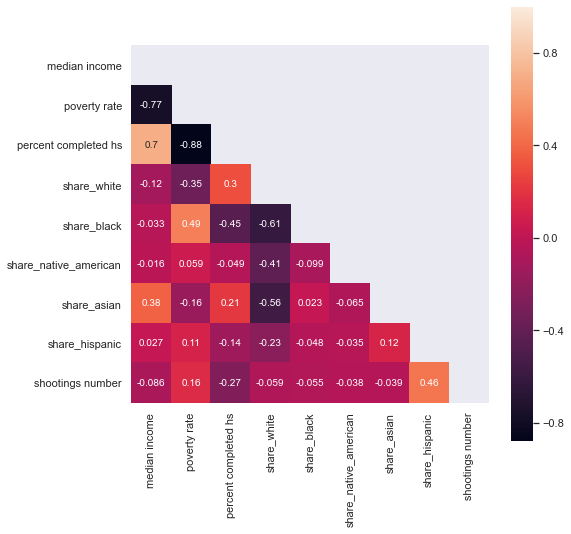

In [16]:
fig, ax = plt.subplots(figsize=(8,8))

# evaluate of correlation matrix
census_kills_corr = census_plus_kills.corr()
# definition of a lower triangular matrix as mask of the heatmap
mask = np.triu(census_kills_corr)
# heatmap print
sns.heatmap(census_kills_corr, annot=True, square=True, mask=mask);

From the heatmat we can see that:
1. *poverty rate*, *percent completed hs* and *median income* have a very high pearson correlation coefficient;
- the correlation between *share_black* and *poverty rate* and *percent completed hs* is also high;
- *shootings number* is only correlated with *share_hispanic*;
- the correlation between *shares* is trivial: since the sum of them should be 100, when one increases others decrease.
    
These statements will be the guide of the future analyses.

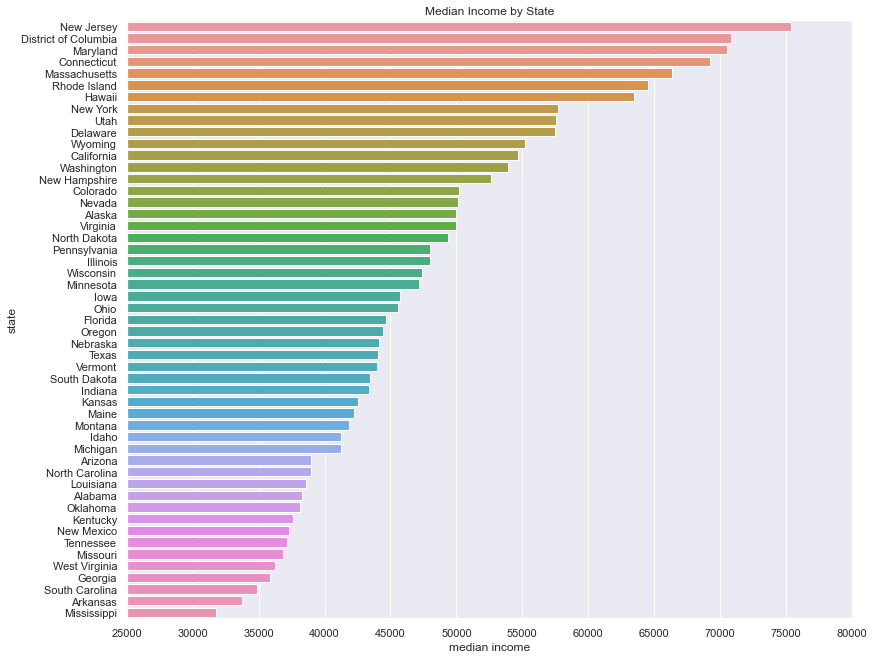

In [17]:
# figure size for some of future plots
size = (13, 11)

# data selection
data = census_plus_kills['median income'].sort_values(ascending=False)

# figure and axes definition
fig, ax = plt.subplots(figsize=size)
# barplot
sns.barplot(x=data, y=data.index)
# definition of x ticks and x limits
plt.xticks(np.arange(25000,80001,5000))
plt.xlim([25000, 80000])
# title setting
plt.title('Median Income by State');

According to this dataset, *New Jersey* is the *state* with the higher *median income*, *Mississipi* the lower.

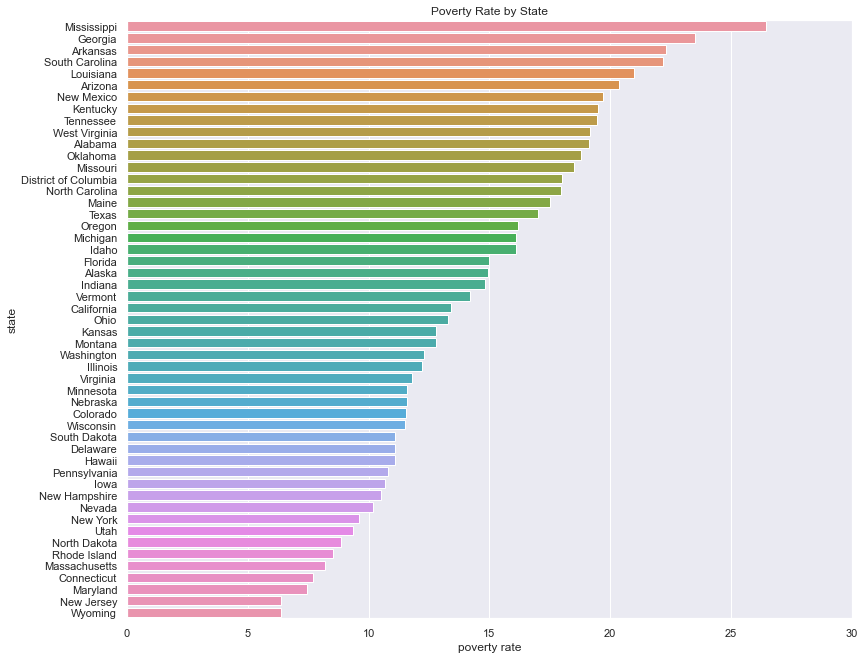

In [18]:
data = census_plus_kills['poverty rate'].sort_values(ascending=False)

fig, ax = plt.subplots(figsize=size)
sns.barplot(data, data.index)
plt.xticks(np.arange(0,31,5));
plt.title('Poverty Rate by State');

*Mississipi* is the higher in *poverty rate*, in alignment with what we saw in the last plot. The same happen with *New Jersey* which is the lower, together with *Wyoming*.

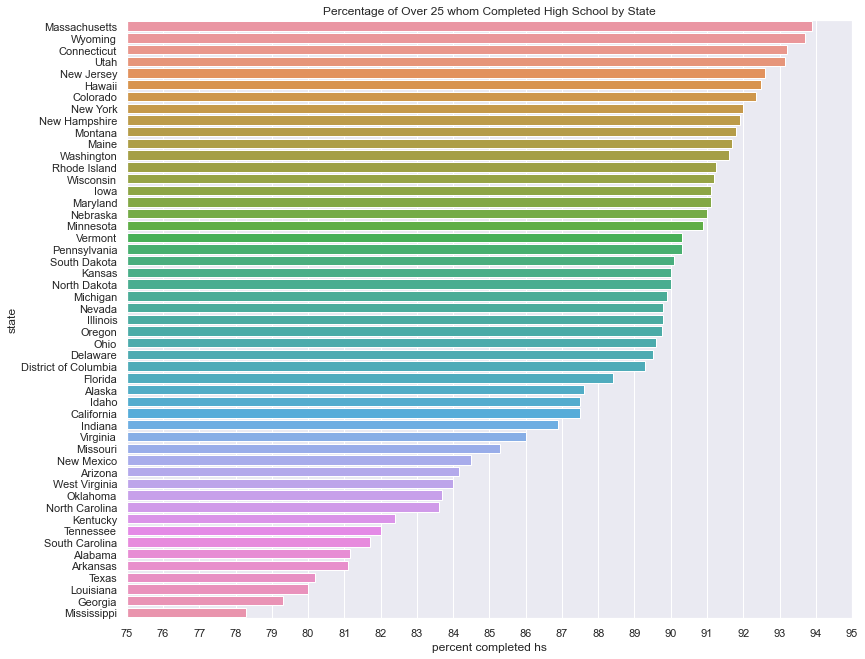

In [19]:
data = census_plus_kills['percent completed hs'].sort_values(ascending=False)

fig, ax = plt.subplots(figsize=size)
sns.barplot(data, data.index)
plt.xticks(np.arange(75,96,1))
plt.xlim([75, 95])
plt.title('Percentage of Over 25 whom Completed High School by State');

Again, *Missisipi* has the lower percent of over 25 whom completed High School. *Wyoming* is on top with *Massachusetts*. 

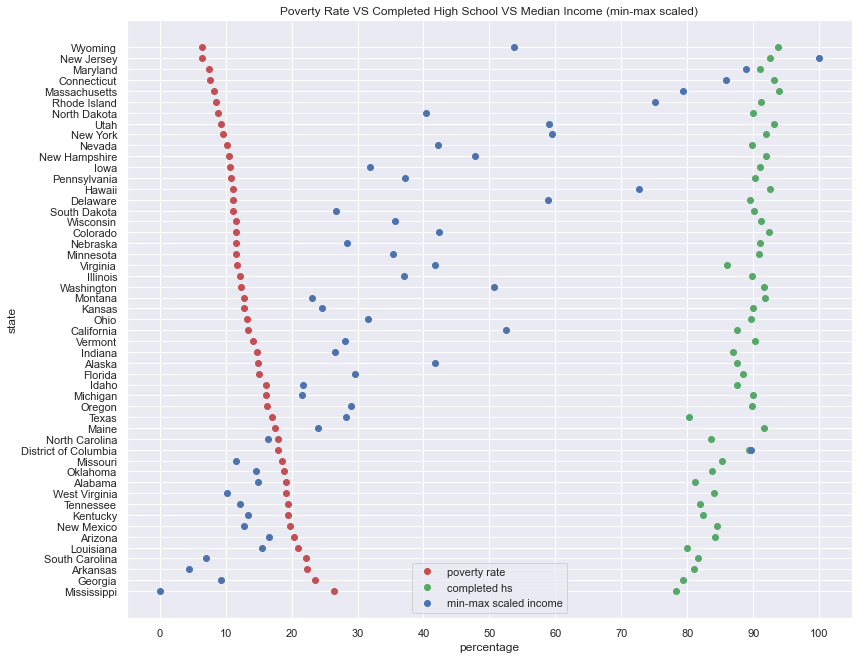

In [20]:
# figure and axes definition
fig, ax = plt.subplots(figsize=size)

# data selection, sorting and plotting in red circles
data = census_plus_kills['poverty rate'].sort_values(ascending=False)
plt.plot(data, data.index, 'ro', label='poverty rate')

# data selection and plotting in green circles
data = census_plus_kills['percent completed hs']
plt.plot(data, data.index, 'go', label='completed hs')

# data selection
data = census_plus_kills['median income']
# min max scaling and plotting in blue circles
data = (data - min(data)) / (max(data)-min(data)) * 100
plt.plot(data, data.index, 'bo', label='min-max scaled income')

# other settings
plt.legend(loc='lower center')
plt.xticks(np.arange(0,101,10))
plt.ylabel('state')
plt.xlabel('percentage')
plt.title('Poverty Rate VS Completed High School VS Median Income (min-max scaled)');

As we can see, while *poverty rate* increases, *median income* and *percent completed hs* decrease.

Let's see now races distribution on US States.

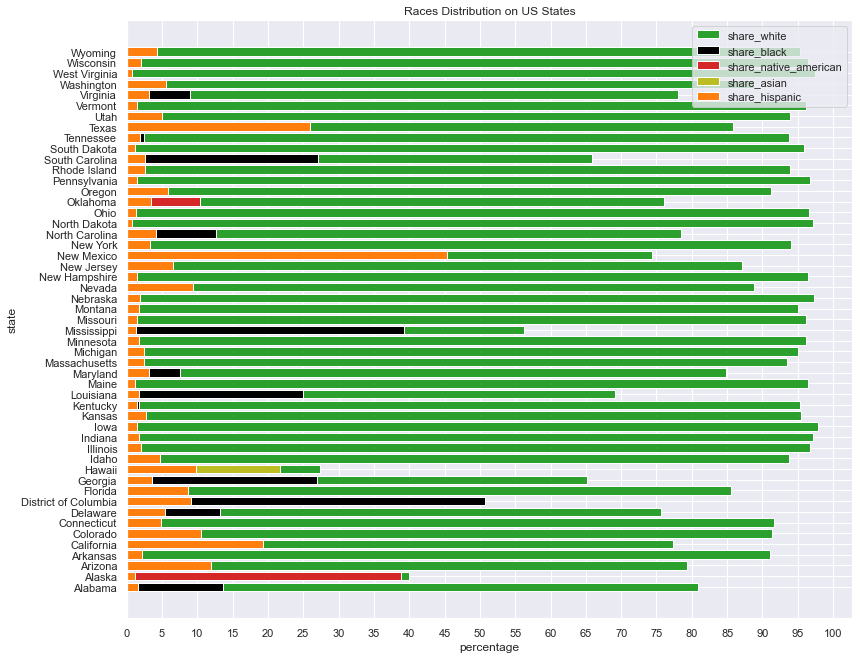

In [21]:
# data selection with index reset
data = census_plus_kills.reset_index()
# figure and axes definition
fig, ax = plt.subplots(figsize=size)
# list of shares columns
shares = [col for col in data.columns if 'share' in col]
# list of colors tag
colors = ['tab:green', 'black', 'tab:red', 'tab:olive', 'tab:orange']
# loop on shares and colors and barplot print
for share, color in zip(shares, colors):
    plt.barh(data['state'], data[share], color=color, label=share)

# other settings
plt.xlabel('percentage')
plt.ylabel('state')
plt.title('Races Distribution on US States')
plt.xticks(np.arange(0, 101, 5))
plt.legend(loc='upper right');

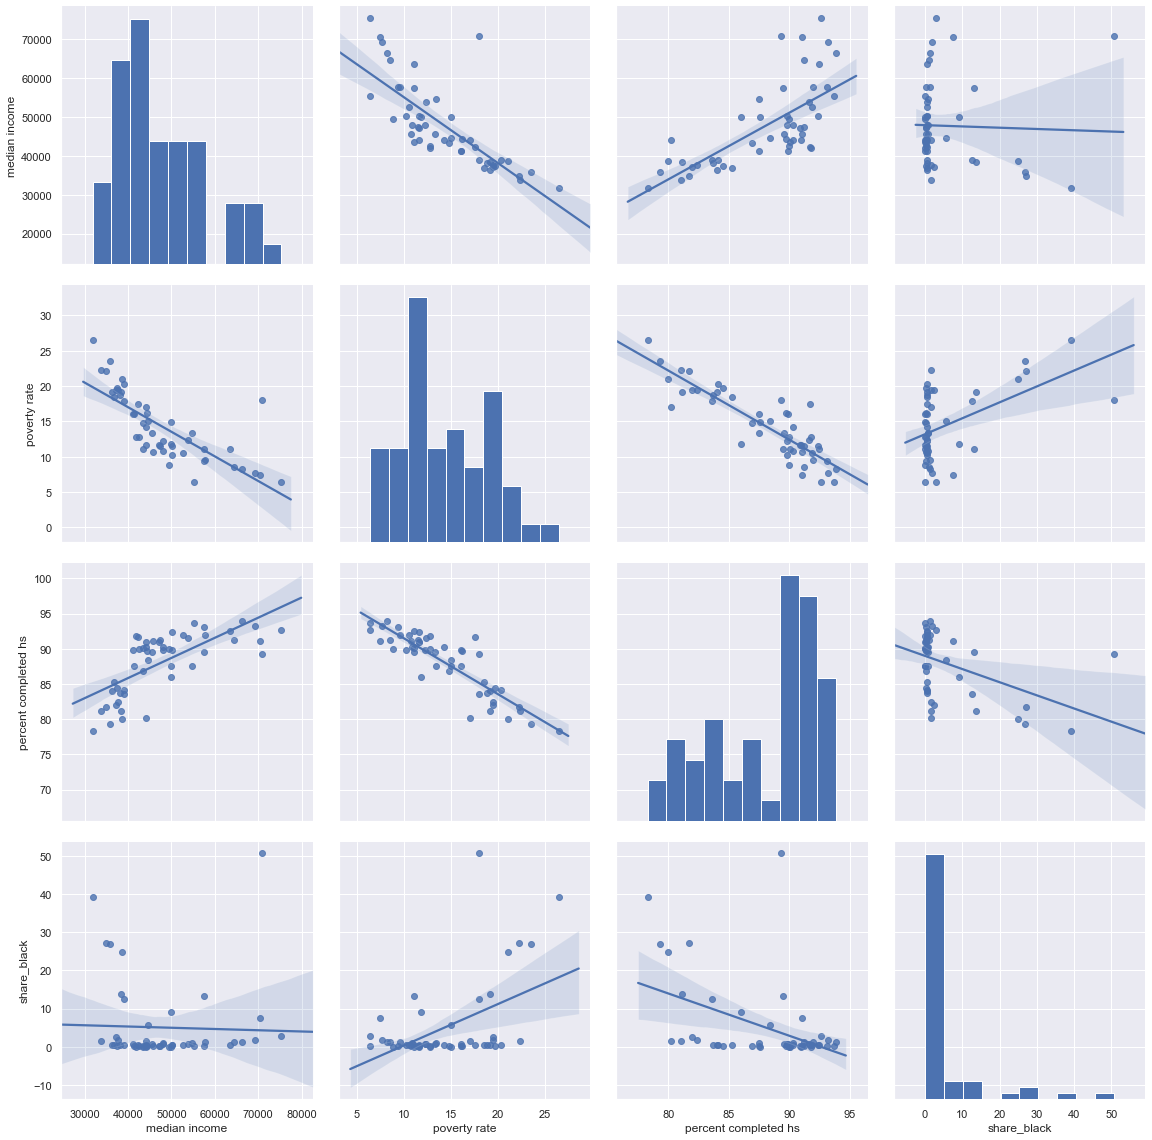

In [22]:
# data selection with index reset
data = census_plus_kills.reset_index()
data = data.loc[:, ['median income', 'poverty rate', 'percent completed hs', 'share_black']]

# pairplot with regression line
sns.pairplot(data, kind='reg', height=4);

As we can see, *median income*, *poverty rate* and *percent completed hs* scatterplots confirm what we saw in the heatmap. From histograms we also see that *median income* and *poverty rate* are right skewed while *percent completed hs* is left skewed.  

On the other hand, *share_black* does not seem related with other variables so what we saw before is not confirmed. From histogram *share_black* is right skewed.

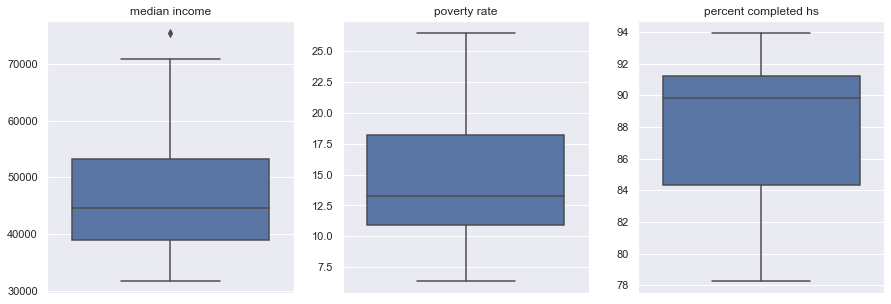

In [23]:
# data selection (share_black remotion)
data = data.iloc[:, :3]
# subplot and figure size definition
fig, ax = plt.subplots(1, data.shape[1], figsize=(15, 5))

# loop on data columns for boxplots
for i, col in enumerate(data.columns):
    sns.boxplot(y=col, data=data, ax=ax[i])
    ax[i].set_ylabel('')
    ax[i].set_title(col)

With this boxplot we end the analysis on these variables. 

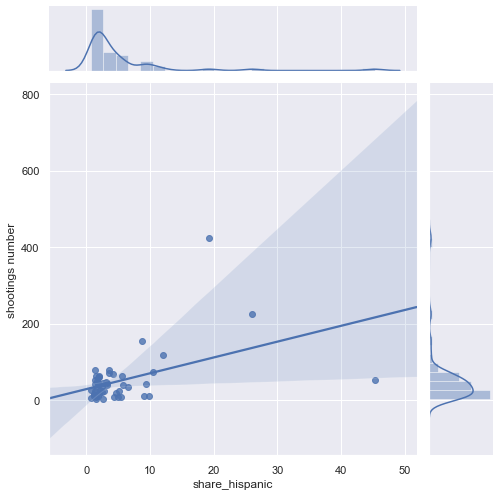

In [24]:
sns.jointplot(x='share_hispanic', y='shootings number', data=census_plus_kills, height=7, kind='reg');

The scatterplot of *share_hispanic* and *shootings number* does not confirm the correlation that we saw before neither. So, probably, there is not a real relation between these variables. From distributions we can state that both variables are right skewed.  

Until now we only anlyzed the <code>census</code> dataset, from this point we will explore <code>killings</code> dataset.

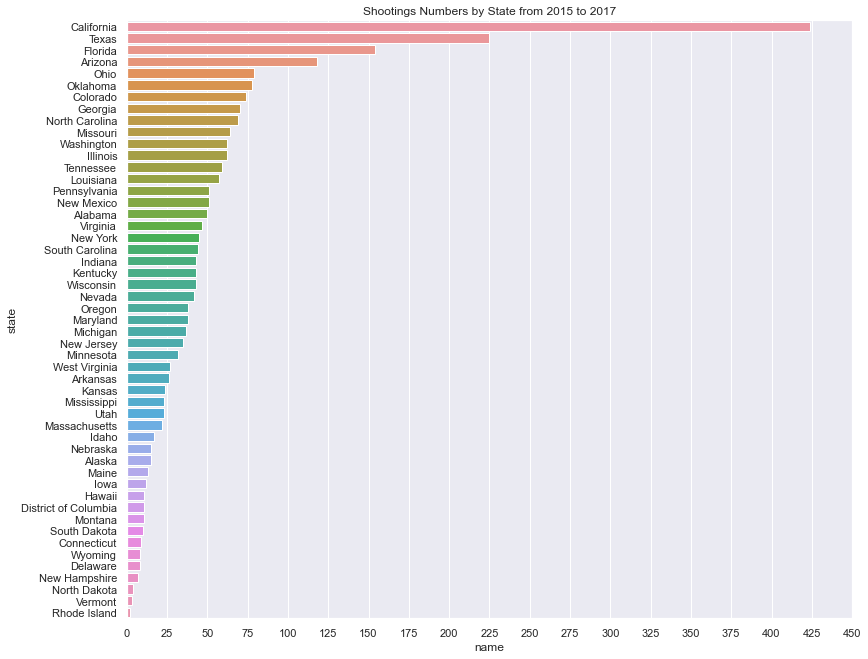

In [25]:
# 'killings' dataset copy
kills = killings.copy()

# group by 'state', counting the number of records and sorting
kills_by_state = kills.groupby(['state'])['name'].count()
kills_by_state.sort_values(ascending=False, inplace=True)

# figure and axes definition
fig, ax = plt.subplots(figsize=size)
# barplot
sns.barplot(x=kills_by_state, y=kills_by_state.index)
# definition of x ticks and x limits
plt.xticks(np.arange(0, 451, 25))
# title setting
plt.title('Shootings Numbers by State from 2015 to 2017');

The state of *California* has the higher number of shootings, *Rhode Island* the lower.

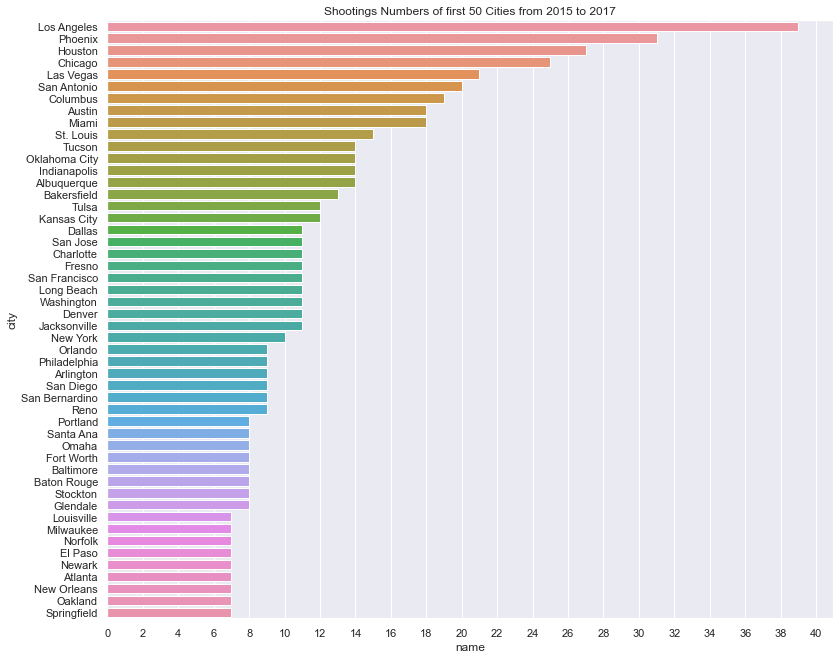

In [26]:
# group by 'city', counting the number of records and sorting
kills_by_city = kills.groupby(['city'])['name'].count()
kills_by_city = kills_by_city.sort_values(ascending=False)[:50]

# figure and axes definition
fig, ax = plt.subplots(figsize=size)
# barplot
sns.barplot(x=kills_by_city, y=kills_by_city.index)
# definition of x ticks and x limits
plt.xticks(np.arange(0, 41, 2))
# title setting
plt.title('Shootings Numbers of first 50 Cities from 2015 to 2017');

The city of *Los Angeles* is the first in shootings frequence, *Springfield* is one of the last.

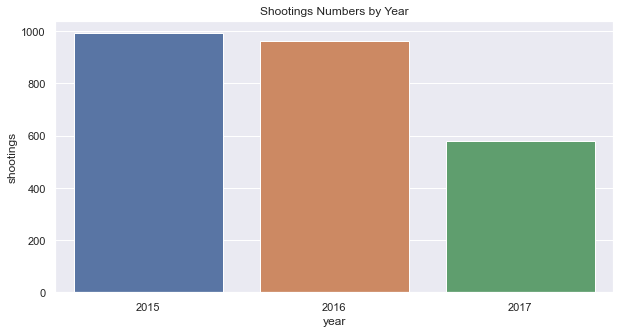

In [27]:
# creation of year, month and day columns from 'date' variable
kills['year'] = pd.DatetimeIndex(kills['date']).year
kills['month'] = pd.DatetimeIndex(kills['date']).month
kills['day'] = pd.DatetimeIndex(kills['date']).day

# group by year, counting the number of records
kills_by_date = kills.groupby(['year'])['name'].count()
# rename of the column with a proper one
kills_by_date.rename(columns={'name': 'count'}, inplace=True)

# figure and axes definition
fig, ax = plt.subplots(figsize=(10, 5))
# barplot
sns.barplot(kills_by_date.index, kills_by_date)
# other options
plt.ylabel('shootings')
plt.title('Shootings Numbers by Year');

From the barplot it seems that *year* 2017 had less shootings while 2015 and 2016 had a similar number, near 1000.

In [28]:
max(kills['date'])

Timestamp('2017-12-07 00:00:00')

Even if the last *date* of 2017 is in december, we cannot state that that year had lower shootings than the other. We whould need to know more on data collection or further analysis.

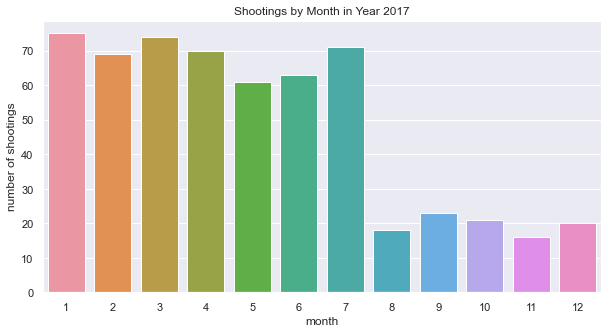

In [29]:
# selection of shootings in year 2017
kills_2017 = kills[kills['year'] == 2017]
# group by month, counting the number of records
kills_2017 = kills_2017.groupby(['month'])['name'].count()

# figure and axes definition
fig, ax = plt.subplots(figsize=(10, 5))

sns.barplot(kills_2017.index, kills_2017)
plt.ylabel('number of shootings')
plt.title('Shootings by Month in Year 2017');

There is something strange here: the shootings number dropped from August 2017. We will not use this year in the future.

The average in years 2015 and 2016 is of 81 shootings per month.


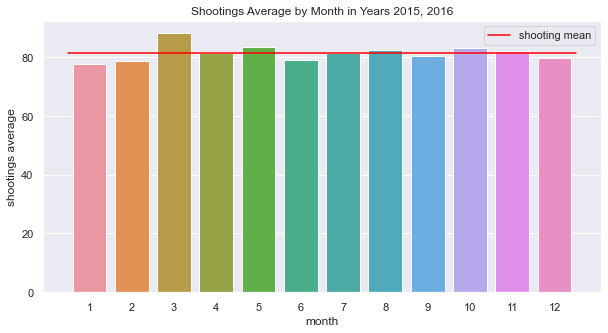

In [30]:
# selection of data in year 2015, 2016
kills_1516 = kills[kills['year'] < 2017]
# group by month, counting the number of records and dividing by the number of years
kills_1516 = kills_1516.groupby(['month'])['name'].count() / 2
# evaluation of months average
kills_mean = kills_1516.sum() / 12
# print of the average
print('The average in years 2015 and 2016 is of %d shootings per month.' % kills_mean)

# figure and axes definition
fig, ax = plt.subplots(figsize=(10, 5))
# barplot
sns.barplot(kills_1516.index, kills_1516)
# line for plotting the average
plt.plot(np.arange(-0.5, 12.5), kills_mean*np.ones(13), 'red', label='shooting mean')
# other settings
plt.legend()
plt.ylabel('shootings average')
plt.title('Shootings Average by Month in Years 2015, 2016');

There is not much difference between months, the number of shooting seems stable to 81. Let's continue seeing the killing rate by race.

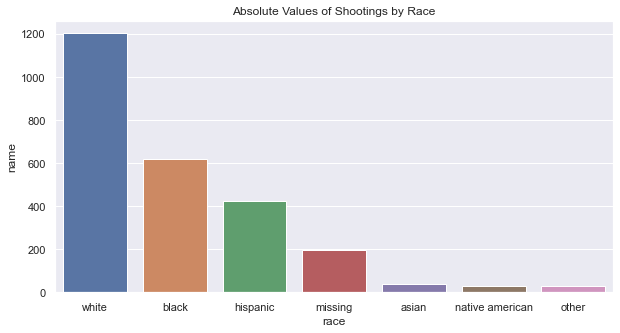

In [31]:
# group by month, counting the number of records and sorting
kills_by_race = kills.groupby(['race'])['name'].count()
kills_by_race.sort_values(ascending=False, inplace=True)

# figure and axes definition
fig, ax = plt.subplots(figsize=(10, 5))
# barplot
sns.barplot(kills_by_race.index, kills_by_race)
# title setting
plt.title('Absolute Values of Shootings by Race');

This is the absolute values of shootings, let's try to obtain a relative number.

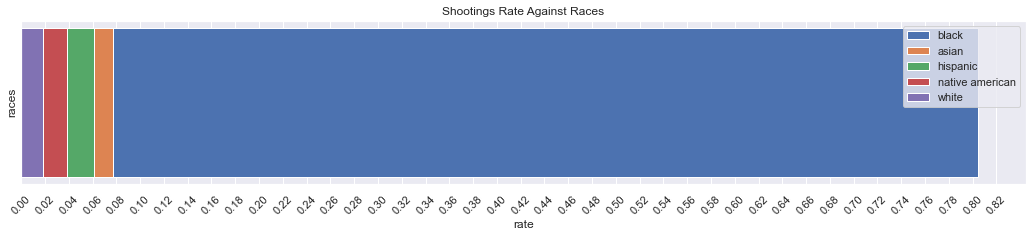

In [32]:
# list of needed columns
races = [col for col in census.columns if 'share' in col]
# group by 'state' column and evaluation the median for each city
races_by_state = census.groupby(['state'])[races].median()
# rename the column to be aligned with the 'killing' dataset
races_by_state.columns = ['white', 'black', 'native american', 'asian', 'hispanic']
# reshape to have races between indexes instead of columns
races_by_state = races_by_state.stack()
# name setting for the Series
races_by_state.name = 'races'
# name setting for MultiIndex
races_by_state.index.names = ['state', 'race']
# list of rows to drop for 'missing' race
kills_to_drop = kills[kills['race'] == 'missing'].index
# drop
kills_dropped = kills.drop(kills_to_drop, axis=0)
# group by 'state' and 'race' and count of the entries for each of them
kills_by_state = kills_dropped.groupby(['state', 'race'])['name'].count()
# name setting for MultiIndex
kills_by_state.name = 'kills'
# left join of datasets on indexes
kills_rate = pd.merge(kills_by_state, races_by_state, how='left', right_index=True, left_index=True)
# new columns evaluation through the division of 'kills' and 'races'
kills_rate['kills rate'] = kills_rate.apply(
    lambda row: 100*row['kills']/row['races'] if row['races'] != 0 else np.NaN,
    axis=1)
# group by 'race', evaluation of the sum of the column 'kills rate' and sort descending
total_kills_by_race = kills_rate.groupby(['race'])['kills rate'].sum().sort_values(ascending=False)
# drop of 'other' race, not present in 'census' dataset
data = total_kills_by_race[:-1]

# plot 
fig, ax = plt.subplots(figsize=(18, 3))

data /= sum(data)

for index, value in zip(data.index, data):
    plt.barh(0, value, label=index)
    
plt.xticks(np.arange(0, 0.83, 0.02), rotation=45)
plt.xlabel('rate')
plt.yticks([])
plt.ylabel('races')
plt.title('Shootings Rate Against Races')
plt.legend();

From the datasets provided it seems that the shootings' rate against black people is way higher respect the others. This rate is evaluated considering race shares of the <code>census</code> dataset. More analysis are needed to confirm this statement.

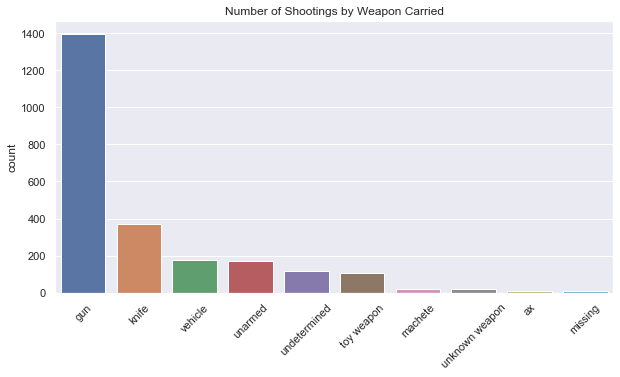

In [33]:
# selecting the value counts of 'armed' column
weapons = kills['armed'].value_counts()
# taking the first 10 weapons
weapons = weapons[:10]

# figure and axes definition
fig, ax = plt.subplots(figsize=(10, 5))
# barplot
sns.barplot(weapons.index, weapons)
# other settings
plt.ylabel('count')
plt.title('Number of Shootings by Weapon Carried')
plt.xticks(rotation=45);

The *gun* is the most frequent weapon, followed by the *knife*. As we can see, there are also shootings against people carring *toy weapons*.

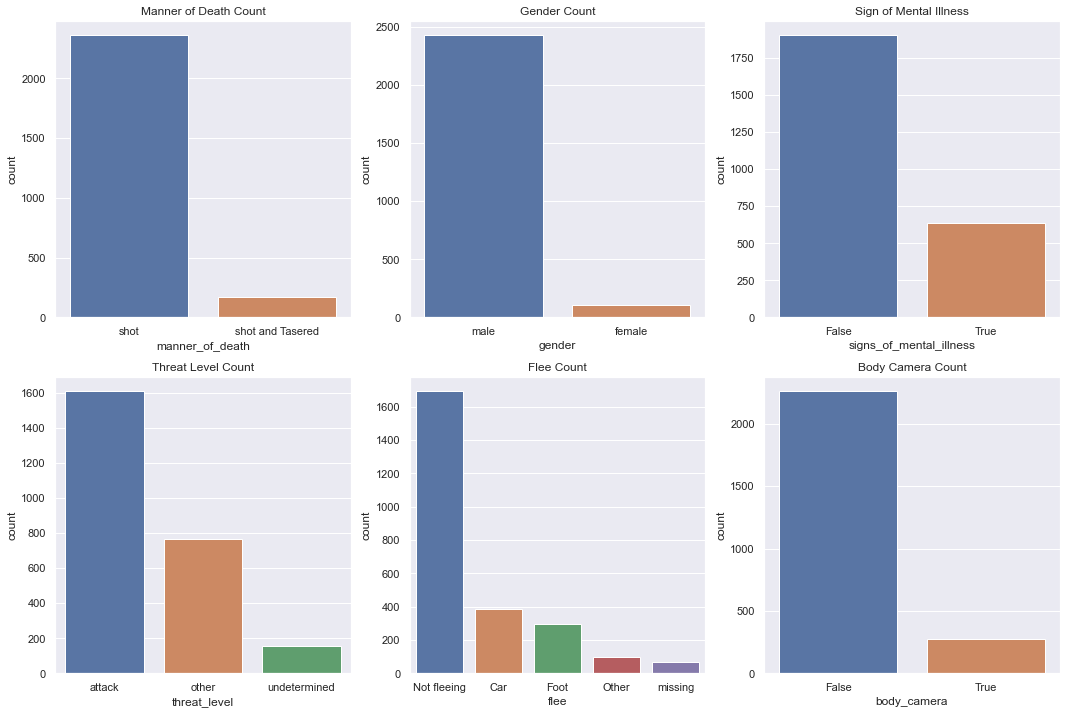

In [34]:
# figure and axes definition
fix, ax = plt.subplots(figsize=(18, 12))

# list of columns to plot
cols_to_plot = ('manner_of_death', 'gender', 'signs_of_mental_illness', 
                'threat_level', 'flee', 'body_camera')
# list of titles to plot
titles_to_plot = ('Manner of Death Count', 'Gender Count', 'Sign of Mental Illness',
                 'Threat Level Count', 'Flee Count', 'Body Camera Count')

# loop on 'cols_to_plot' and print of the countplots
for i, col_name in enumerate(cols_to_plot):
    plt.subplot(2, 3, i+1)
    sns.countplot(kills[col_name])
    plt.title(titles_to_plot[i])

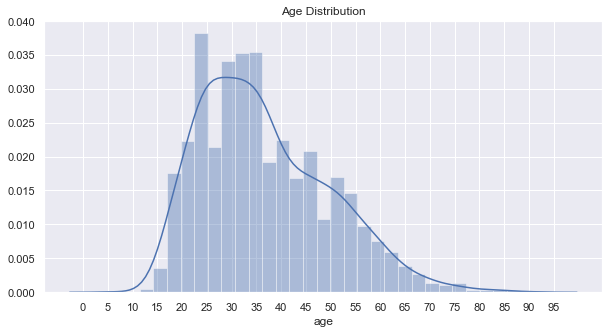

In [35]:
# figure and axes definition
fig, ax = plt.subplots(figsize=(10, 5))
# distribution plot, dropping missing values of 'age' column
sns.distplot(kills['age'].dropna())
# other settings
plt.xticks(np.arange(0, 100, 5))
plt.title('Age Distribution');

As we see in the plot, *age* distribution is right skewed and the most common values are between 25 and 35 years old.

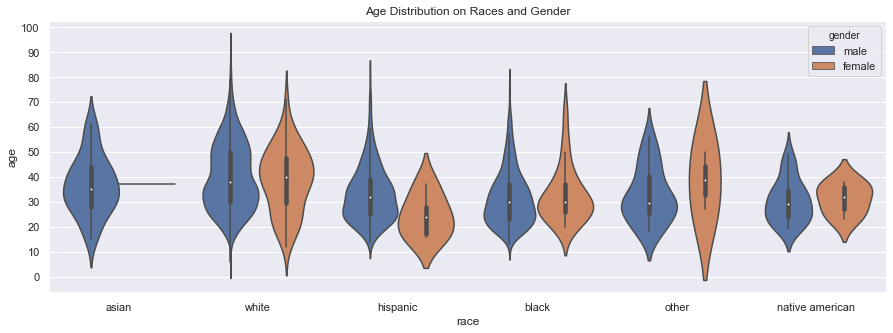

In [36]:
# selection of shootings with a race different from 'missing'
data = kills[kills['race'] != 'missing']

# figure and axes definition
fig, ax = plt.subplots(figsize=(15, 5))
# violinplot with hue
sns.violinplot(x='race', y='age', data=data, hue='gender')
# other settings
plt.yticks(np.arange(0, 101, 10))
plt.title('Age Distribution on Races and Gender');

For the hispanic *race*, it seems that females have lower age than males, the center is also 10 years lower. Other races distributions are similar.

## Conclusion

This notebook provided a preliminary analysis of shooting data collected by the Post and several census information. Some of the key points that we saw here are:
- the confirmed relation between the poverty rate, the median income and the percent of people over 25 whom completed high school;
- the misleading correlation between the percentage of black people with high school completition and the number of shooting with the percentage of hispanic people;
- the very high rate of black people shooted respect the population share.

Futher analyses are possible and postponed to future work.